In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import itertools
%matplotlib inline

In [1]:
import pyspark
import os

conf = pyspark.SparkConf()
ctx = pyspark.SparkContext(conf=conf)

TypeError: 'JavaPackage' object is not callable

In [5]:
sc.textFile(r'C:\Spinn3r\amazon\metadata.json.gz')

NameError: name 'sc' is not defined

In [41]:
file = 'meta_Cell_Phones_and_Accessories.json'
records = []
with open(file, encoding='utf-8') as jdata:
    for line in jdata:
        records.append(ast.literal_eval(line))

In [42]:
records[6712]

{'asin': 'B000JFFRR2',
 'categories': [['Cell Phones & Accessories',
   'Accessories',
   'Batteries',
   'Internal Batteries']],
 'description': '\\\\"\\\\"\\\\"\\\\"Only Fits with Nokia 6103, 6102i, 6102, 6101 \\\\"\\\\"\\\\"\\\\"',
 'imUrl': 'http://ecx.images-amazon.com/images/I/41MNGk7f3zL._SY300_.jpg',
 'salesRank': {'Cell Phones & Accessories': 640115},
 'title': '3 Pieces Value Combo Of Brand New Nokia 6103, 6102i, 6102, 6101,Nokia 5200, 5300 / XpressMusic, 6110, 6300, 7390 Vehicle Power Charger with IC Chip + Home Travel Wall Plug In Ac Charger + Standard Lithium-Ion Battery BL-4C 750mah'}

In [43]:
name_id_mapping = {}
for i, record in enumerate(records):
    name_id_mapping[record['asin']] = i

In [44]:
len(name_id_mapping)

346793

In [134]:
adj_list = []
adj_set = []
for record in records:
    if 'related' in record and 'buy_after_viewing' in record['related']: # also_viewed
        av = record['related']['buy_after_viewing']
    else:
        av = []
    av = list(filter(lambda x: x in name_id_mapping, av))
    adj_list.append(sorted(set([name_id_mapping[x] for x in av])))
    
    if 'related' in record and 'bought_together' in record['related']: # also_viewed
        bt = record['related']['bought_together']
    else:
        bt = []
    bt = list(filter(lambda x: x in name_id_mapping, bt))
    bt = [name_id_mapping[x] for x in bt]
    for o in bt:
        if o in adj_list[-1]:
            adj_list[-1].remove(o)
    adj_set.append(frozenset(adj_list[-1]))

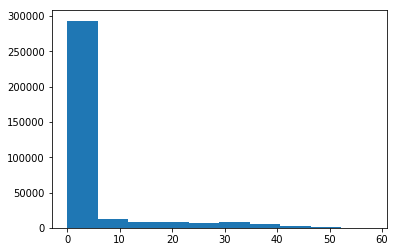

In [46]:
num_viewed = np.array([len(x) for x in adj_list])
_ = plt.hist(num_viewed)

In [203]:
# Number of 2-cliques
n_cliq = 0
for i, edges in enumerate(adj_list):
    for e in edges:
        if i in adj_list[e]:
            n_cliq += 1

In [204]:
n_cliq/2

58868.0

In [75]:
np.sum(num_viewed > 0)

80727

In [154]:
#adj_list = [[1, 2], [0, 2], [0, 1]]
# Number of 3-cliques
n_cliq = 0
for a, edges_a in enumerate(adj_list):
    for b in edges_a:
        if a in adj_list[b]:
            for c in adj_list[b]:
                if c == a:
                    continue
                if a in adj_list[c] and b in adj_list[c]:
                    n_cliq += 1

In [155]:
n_cliq/6

40318.833333333336

In [98]:
# Number of 4-cliques
#adj_list = [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
n_cliq = 0
cliques = []
for a, edges_a in enumerate(adj_list):
    for b in edges_a:
        if a in adj_list[b]:
            for c in adj_list[b]:
                if c == a:
                    continue
                if a in adj_list[c] and b in adj_list[c]:
                    for d in adj_list[c]:
                        if d == a or d == b or d == c:
                            continue
                        if a in adj_list[d] and b in adj_list[d] and c in adj_list[d]:
                            cliques.append([a, b, c, d])
                            n_cliq += 1

In [99]:
n_cliq/24

34714.375

In [119]:
for i in cliques[1000]:
    print(records[i]['title'])

Nokia 6131 Unlocked Cell Phone withCamera, Media Player, MicroSD Slot--International Version with No Warranty (Black)
Nokia E66 Unlocked Phone with 3.2 MP Camera, International 3G, Wi-Fi, Media Player, and MicroSD Slot--International Version with Warranty (Gray)
Nokia 6500 Slide Black/silver Unlocked Cell Phone
Nokia 6500 Classic 1 GB Unlocked Cell Phone with 2 MP Camera, International 3G, Media Player--International Version with No Warranty (Black)


In [125]:
num_q = 0
for t in itertools.combinations(range(len(adj_list)), 2):
    is_clique = True
    for i in range(len(t) - 1):
        for j in range(i + 1, len(t)):
            if t[i] not in adj_list[t[j]] or t[j] not in adj_list[t[i]]:
                is_clique = False
                break
    if is_clique:
        num_q += 1

KeyboardInterrupt: 

In [126]:
num_q

19

In [159]:
import bisect

def extract_cliques(nodes, prev_list, deg, max_deg):
    if deg == max_deg:
        print(prev_list)
        return 1
    
    count = 0
    m = 0 if len(prev_list) == 0 else bisect.bisect_right(nodes, prev_list[-1])
    for a in nodes[m:]:
        connected = True
        for test in prev_list:
            if test not in adj_set[a] or a not in adj_set[test]:
                connected = False
                break
        
        if connected:
            prev_list.append(a)
            count += extract_cliques(adj_list[a], prev_list, deg + 1, max_deg)
            prev_list.pop()
    return count

In [165]:
#adj_list = [[1, 2], [0, 2], [0, 1]]
print(extract_cliques(range(len(adj_list)), [], 0, 4))

[3541, 4165, 5871, 7388]
[3541, 4165, 5871, 14647]
[4476, 8032, 223340, 264381]
[6335, 22627, 24843, 266831]
[6724, 9660, 20902, 28463]
[7591, 31791, 70858, 264396]
[9133, 23791, 75886, 125975]
[10444, 10465, 60685, 71655]
[10769, 18032, 34787, 75880]
[15344, 17512, 38113, 234098]
[15344, 17512, 38113, 253736]
[15980, 22761, 31204, 82561]
[19174, 19372, 25401, 25410]
[21539, 22077, 23113, 34774]
[22303, 25045, 70818, 90369]
[22306, 70861, 175020, 278750]
[22306, 70861, 265449, 278750]
[25120, 34773, 265500, 287055]
[25120, 259155, 265500, 287055]
[34784, 42170, 65983, 88136]
[34784, 42170, 65983, 265461]
[34784, 42170, 88136, 265461]
[34784, 65983, 88136, 265461]
[35330, 41059, 89815, 265485]
[36581, 51165, 61464, 99300]
[41057, 45608, 63041, 71734]
[41057, 45608, 63041, 73415]
[41057, 45608, 71734, 73415]
[41057, 63041, 71734, 73415]
[42170, 65983, 88136, 265461]
[42323, 62269, 74017, 100948]
[44292, 60011, 67964, 107069]
[45437, 62041, 83608, 136814]
[45437, 62041, 83608, 238544]
[45

In [139]:
def extract_all_cliques(nodes, prev_list):
    count = 0
    m = 0 if len(prev_list) == 0 else bisect.bisect_right(nodes, prev_list[-1])
    for a in nodes[m:]:
        connected = True
        for test in prev_list:
            if test not in adj_set[a] or a not in adj_set[test]:
                connected = False
                break
        
        if connected:
            prev_list.append(a)
            if extract_all_cliques(adj_list[a], prev_list) == 0:
                if len(prev_list) > 1:
                    print(prev_list)
                count += 1
            prev_list.pop()
    return count

%timeit print(extract_all_cliques(range(len(adj_list)), []))

[0, 138232]
[53, 177013]
[63, 216213]
[124, 273348]
[124, 296539]
[131, 290770]
[132, 45621]
[132, 132029]
[145, 201701, 207155]
[145, 207155]
[145, 301890]
[191, 50069]
[216, 48289]
[281, 5806]
[283, 18004]
[292, 1589]
[292, 130941]
[295, 69468]
[317, 40423]
[318, 1585, 125723]
[318, 1595]
[318, 122369]
[318, 125723]
[339, 1680]
[339, 105221]
[339, 150367]
[341, 1632]
[341, 130941]
[342, 40834]
[342, 40842]
[349, 31931]
[354, 1714]
[357, 105140]
[378, 9535]
[490, 95991]
[490, 103811]
[545, 195932]
[593, 307725]
[594, 193651]
[616, 641]
[633, 147921]
[701, 211572]
[731, 77876]
[888, 91352, 130774]
[888, 130774]
[889, 936]
[903, 215913]
[903, 218445]
[960, 95066]
[965, 227123]
[1014, 94477]
[1014, 104719]
[1027, 108078]
[1038, 1087]
[1047, 115723]
[1130, 147130]
[1266, 36899]
[1326, 1682]
[1346, 1427]
[1346, 34167]
[1351, 125725]
[1355, 11988]
[1355, 18404]
[1355, 22077]
[1425, 18014]
[1565, 14875]
[1565, 125876]
[1565, 217149]
[1585, 125723]
[1589, 1632]
[1622, 54130]
[1630, 1689]
[163

[28675, 41465]
[28711, 261216]
[28729, 29323]
[28770, 29500]
[28777, 122885]
[28832, 47326]
[28848, 28849]
[28861, 30924]
[28930, 42724]
[28944, 109192]
[28945, 33523]
[29002, 30019]
[29021, 62038]
[29021, 128235]
[29095, 39243]
[29106, 43147]
[29131, 29789]
[29179, 31262]
[29304, 65783]
[29364, 30850]
[29390, 116513]
[29437, 171277]
[29656, 36164]
[29719, 34899]
[29740, 29792]
[29740, 110784]
[29760, 29889]
[29773, 29816]
[29788, 80624]
[29826, 40945]
[29877, 80667]
[29877, 122701]
[30004, 65773]
[30019, 35687]
[30056, 102408]
[30097, 31404]
[30097, 41673]
[30118, 30202]
[30166, 167117]
[30175, 183821]
[30194, 33913, 36949]
[30194, 36949]
[30194, 54069]
[30237, 30924]
[30317, 132207]
[30389, 62177]
[30408, 52639]
[30419, 33554]
[30484, 80649]
[30503, 30511]
[30508, 53135]
[30580, 52639]
[30619, 80631]
[30633, 50778]
[30766, 30768]
[30810, 75082]
[30810, 266832]
[30819, 40532, 41556]
[30819, 41556]
[30901, 40025]
[30932, 68756]
[30933, 62200]
[30943, 73630]
[30963, 32979]
[30963, 33442

[80596, 93837]
[80599, 106231]
[80604, 84734]
[80610, 122584]
[80623, 124322]
[80630, 82334]
[80630, 122582]
[80630, 122725]
[80645, 80687]
[80649, 165721]
[80668, 254279]
[80669, 93235]
[80670, 122895]
[80670, 165174]
[80693, 80743]
[80702, 135653]
[80703, 122647]
[80704, 122656]
[80708, 148748]
[80717, 82673]
[80730, 106030]
[80733, 82328]
[80738, 122892]
[80741, 118655]
[80743, 236946]
[80755, 118653]
[80762, 122671]
[80771, 81076]
[80777, 81086]
[80799, 99360]
[80844, 95328]
[80854, 91342]
[80890, 83447]
[80898, 80899]
[80916, 91719]
[81027, 85936]
[81045, 85936]
[81115, 119337]
[81133, 81460]
[81134, 81464]
[81137, 85446]
[81148, 104973]
[81174, 81473, 82844]
[81174, 82844]
[81177, 81565]
[81183, 82891]
[81186, 82833]
[81186, 165778]
[81201, 81993]
[81202, 81481]
[81204, 86324]
[81212, 81466]
[81219, 81496]
[81223, 81472]
[81223, 271487]
[81234, 81496]
[81237, 81478]
[81241, 82853]
[81249, 81524]
[81256, 81486]
[81257, 81492]
[81257, 136353]
[81265, 81482]
[81289, 81293]
[81359, 1

[126535, 129164]
[126543, 127239]
[126543, 172082]
[126571, 341771]
[126632, 128073]
[126649, 208376]
[126805, 131828]
[126822, 127060]
[126823, 127838]
[126932, 130418]
[126967, 190638]
[127045, 208370]
[127050, 189492]
[127056, 130421]
[127090, 133571]
[127095, 127100]
[127095, 131153]
[127156, 127161]
[127183, 129343]
[127185, 242492]
[127216, 127536]
[127278, 265287]
[127287, 127288]
[127398, 291888]
[127437, 137641]
[127521, 148270]
[127536, 133385]
[127562, 165179]
[127593, 227816]
[127688, 209086]
[127729, 131136]
[127747, 131622]
[127754, 129706]
[127755, 129095]
[127760, 129784]
[127914, 267201]
[127986, 127987]
[127989, 132188]
[127997, 338045]
[128017, 251523, 267999]
[128017, 267999]
[128024, 282861]
[128041, 286862]
[128049, 138296]
[128168, 135726]
[128182, 128185]
[128183, 128186]
[128185, 292329]
[128211, 229140]
[128219, 184011]
[128235, 265450]
[128295, 130002]
[128422, 128441]
[128450, 128453]
[128473, 140475]
[128509, 220251, 224740]
[128509, 224740]
[128517, 166002

[175955, 211407]
[176118, 223104]
[176148, 213673]
[176174, 218895]
[176190, 213006]
[176324, 176327]
[176382, 189017]
[176389, 240040]
[176402, 176403]
[176402, 176404]
[176406, 231653]
[176409, 231653]
[176411, 266948, 275564]
[176411, 275564]
[176420, 253236]
[176420, 288151]
[176422, 254007]
[176429, 176436]
[176429, 211089]
[176430, 176976, 204097]
[176430, 178953]
[176430, 204097]
[176590, 277709]
[176593, 178921]
[176593, 242356]
[176594, 180637]
[176608, 232615]
[176614, 183673]
[176668, 177858]
[176668, 282550]
[176717, 176724]
[176724, 204844]
[176726, 211499]
[176726, 211505]
[176735, 234236]
[176750, 278156]
[176777, 183050]
[176783, 177907]
[176784, 214042]
[176813, 275473]
[176815, 182994]
[176825, 239430]
[176839, 178156]
[176844, 178156]
[176890, 203377]
[176890, 203382]
[176919, 331727]
[176923, 258339]
[176930, 331727]
[176931, 331727]
[176945, 176967, 181773]
[176945, 181773]
[176961, 209018]
[176967, 181773]
[176976, 204097]
[176997, 178576]
[176998, 181472]
[177010

[216923, 219755]
[216950, 254626, 254630]
[216950, 254630]
[216971, 239774]
[216986, 216994]
[216986, 216998]
[217003, 218343]
[217008, 218835]
[217210, 220599]
[217282, 299740]
[217290, 223391]
[217322, 288872]
[217349, 217354]
[217416, 217417, 217422]
[217416, 217422]
[217417, 217422]
[217422, 217423]
[217458, 217459]
[217458, 217464, 248622]
[217458, 248622]
[217459, 291376]
[217461, 272582]
[217462, 217468]
[217464, 248622]
[217527, 217528]
[217537, 217540]
[217540, 228096]
[217548, 275281]
[217549, 217553]
[217561, 229185]
[217568, 240081]
[217569, 229040]
[217608, 245853]
[217622, 217899, 225520]
[217622, 225520]
[217629, 232532]
[217642, 325334]
[217651, 217659]
[217659, 226518]
[217670, 240016]
[217676, 240016]
[217711, 221291]
[217817, 225511]
[217826, 223048]
[217843, 238797]
[217860, 217865]
[217899, 225520]
[217914, 256199]
[217934, 236906]
[217945, 295754]
[217957, 219132]
[218034, 229223]
[218044, 218048]
[218047, 218048, 218051]
[218047, 218051]
[218048, 218049]
[218048,

[265449, 278750]
[265492, 290941]
[265496, 267196]
[265500, 287055]
[265672, 282168]
[265695, 269542]
[265697, 286355]
[265712, 335060]
[265745, 322247]
[265748, 267802]
[265780, 319514]
[265788, 323623]
[265807, 275792]
[265814, 265815]
[265836, 327069]
[265846, 319987]
[265865, 265878]
[265914, 265925]
[265955, 265956]
[265968, 308082]
[266087, 293844]
[266098, 266860]
[266111, 287069]
[266240, 305922]
[266240, 321866]
[266252, 284144, 300126]
[266252, 300126]
[266256, 271810]
[266256, 271837]
[266256, 279841]
[266294, 266327]
[266294, 266339]
[266298, 266327]
[266306, 266313]
[266321, 266361]
[266321, 267279]
[266326, 266328]
[266355, 267279]
[266358, 267279]
[266369, 268162]
[266394, 270032]
[266453, 304181]
[266509, 300537]
[266527, 279802]
[266534, 279144]
[266556, 269663]
[266656, 268392, 288843]
[266656, 268392, 290917]
[266656, 288843]
[266656, 290805]
[266656, 290917]
[266675, 266679]
[266711, 272237]
[266736, 312409]
[266757, 266758, 266765]
[266757, 266765]
[266757, 266767]

KeyboardInterrupt: 

In [173]:
arr = [130563, 130565, 141292, 221663]
for i in arr:
    print(records[i]['title'], records[i]['price'], records[i]['salesRank'])

HTC One X 16GB Unlocked GSM Phone with Android 4.0 OS, Audio Beats, Super IPS LCD2 Touchscreen, 8MP Camera, GPS, Wi-Fi and Bluetooth - Gray 235.0 {'Cell Phones & Accessories': 2349}
HTC One X with Beats Audio Unlocked GSM Android SmartPhone - No Warranty - White 237.8 {'Cell Phones & Accessories': 2400}
HTC S720E One X Unlocked Android SmartPhone with 32GB Memory, 8MP HD Camera, Bluetooth, Wi-Fi - No Warranty - Black 266.14 {'Cell Phones & Accessories': 12124}
HTC ONE X UNLOCKED AT&amp;T World Phone - 16GB Memory - DUAL CORE Processor - No Contract (WHITE) 264.56 {'Cell Phones & Accessories': 12367}
